<a href="https://colab.research.google.com/github/ztlouis/HDB-Resale-Prices-Regression/blob/main/HDB_Resale_Prices_Prediction_using_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import time
import seaborn as sns
import sklearn
from matplotlib.ticker import EngFormatter
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [ ]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/ResaleFLatPricesFromJan2027_retrieved16Oct25.csv")

pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
df # get an idea of the dataset, and also its shape.

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.00,Improved,1979,61 years 04 months,232000.00
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.00,New Generation,1978,60 years 07 months,250000.00
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,262000.00
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.00,New Generation,1980,62 years 01 month,265000.00
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,265000.00
...,...,...,...,...,...,...,...,...,...,...,...
217648,2025-07,YISHUN,EXECUTIVE,824,YISHUN ST 81,04 TO 06,146.00,Maisonette,1987,61 years 05 months,980000.00
217649,2025-09,YISHUN,EXECUTIVE,877,YISHUN ST 81,10 TO 12,145.00,Maisonette,1987,61 years 03 months,980000.00
217650,2025-09,YISHUN,EXECUTIVE,834,YISHUN ST 81,04 TO 06,146.00,Maisonette,1988,61 years 04 months,990000.00
217651,2025-05,YISHUN,MULTI-GENERATION,632,YISHUN ST 61,04 TO 06,147.00,Multi Generation,1987,61 years 06 months,945000.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217653 entries, 0 to 217652
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                217653 non-null  object 
 1   town                 217653 non-null  object 
 2   flat_type            217653 non-null  object 
 3   block                217653 non-null  object 
 4   street_name          217653 non-null  object 
 5   storey_range         217653 non-null  object 
 6   floor_area_sqm       217653 non-null  float64
 7   flat_model           217653 non-null  object 
 8   lease_commence_date  217653 non-null  int64  
 9   remaining_lease      217653 non-null  object 
 10  resale_price         217653 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 18.3+ MB


In [ ]:
df.nunique() # get an idea of how many unique entries there are for each attribute


,0
month,106
town,26
flat_type,7
block,2743
street_name,576
storey_range,17
floor_area_sqm,186
flat_model,21
lease_commence_date,57
remaining_lease,692


In [ ]:
df.isna().sum() # check for missing data, in this case no missing data

,0
month,0
town,0
flat_type,0
block,0
street_name,0
storey_range,0
floor_area_sqm,0
flat_model,0
lease_commence_date,0
remaining_lease,0


In [ ]:
dupes = df.duplicated().sum() # get count of duplicated rows
print(f'There are {dupes} duplicated rows present.')

There are 306 duplicated rows present.


In [ ]:
# remove duplicates
print(df.shape)
df.drop_duplicates(inplace = True)
print(df.shape)
print(f'After removing duplicates there are {df.shape[0]} rows remaining.')

(217653, 11)
(217347, 11)
After removing duplicates there are 217347 rows remaining.


In [ ]:
# new columns, easier to work with and understand than their original counterparts
def duration_to_months(s):
    years = re.search(r'(\d+)\s*year', s)
    months = re.search(r'(\d+)\s*month', s)

    yr = int(years.group(1)) if years else 0
    m = int(months.group(1)) if months else 0

    return yr * 12 + m

df['remaining_lease_in_months'] = df['remaining_lease'].apply(duration_to_months)

def duration_to_years(s):
    years = re.search(r'(\d+)\s*year', s)
    months = re.search(r'(\d+)\s*month', s)

    yr = int(years.group(1)) if years else 0
    m = int(months.group(1)) if months else 0

    return (yr * 12 + m)/12

df['remaining_lease_in_years'] = df['remaining_lease'].apply(duration_to_years)

def avg_storey_range(storey_range):
    parts = storey_range.split(' TO ')
    return (int(parts[0]) + int(parts[1])) // 2
df['average_storey'] = df['storey_range'].apply(avg_storey_range)

df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,remaining_lease_in_months,remaining_lease_in_years,average_storey
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.00,Improved,1979,61 years 04 months,232000.00,736,61.33,11
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.00,New Generation,1978,60 years 07 months,250000.00,727,60.58,2
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,262000.00,749,62.42,2
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.00,New Generation,1980,62 years 01 month,265000.00,745,62.08,5
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,265000.00,749,62.42,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217648,2025-07,YISHUN,EXECUTIVE,824,YISHUN ST 81,04 TO 06,146.00,Maisonette,1987,61 years 05 months,980000.00,737,61.42,5
217649,2025-09,YISHUN,EXECUTIVE,877,YISHUN ST 81,10 TO 12,145.00,Maisonette,1987,61 years 03 months,980000.00,735,61.25,11
217650,2025-09,YISHUN,EXECUTIVE,834,YISHUN ST 81,04 TO 06,146.00,Maisonette,1988,61 years 04 months,990000.00,736,61.33,5
217651,2025-05,YISHUN,MULTI-GENERATION,632,YISHUN ST 61,04 TO 06,147.00,Multi Generation,1987,61 years 06 months,945000.00,738,61.50,5


In [ ]:
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,remaining_lease_in_months,remaining_lease_in_years,average_storey
count,217347.00,217347.00,217347.00,217347.00,217347.00,217347.00
mean,96.82,1996.40,521884.23,891.60,74.30,8.77
std,24.03,14.28,185135.92,170.44,14.20,5.94
min,31.00,1966.00,140000.00,481.00,40.08,2.00
25%,81.00,1985.00,385000.00,751.00,62.58,5.00
50%,93.00,1997.00,490000.00,889.00,74.08,8.00
75%,112.00,2012.00,628000.00,1064.00,88.67,11.00
max,366.70,2022.00,1658888.00,1173.00,97.75,50.00


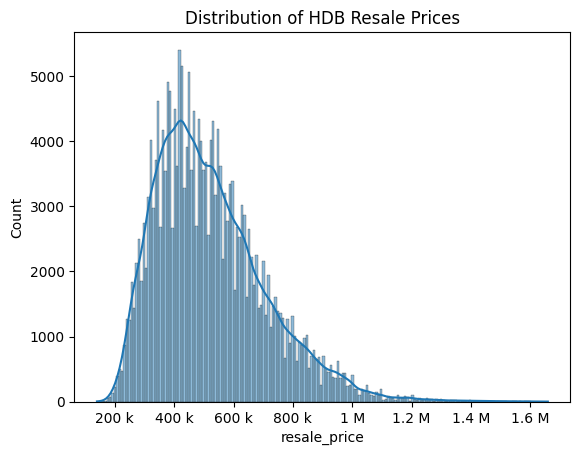

Skewness: 0.9506379464031036


In [ ]:
ax = sns.histplot(df['resale_price'], kde=True)
ax.xaxis.set_major_formatter(EngFormatter()) #format to k and M as units, cleaner
plt.title("Distribution of HDB Resale Prices")
plt.show()

# Check for skewness
print("Skewness:", df['resale_price'].skew())

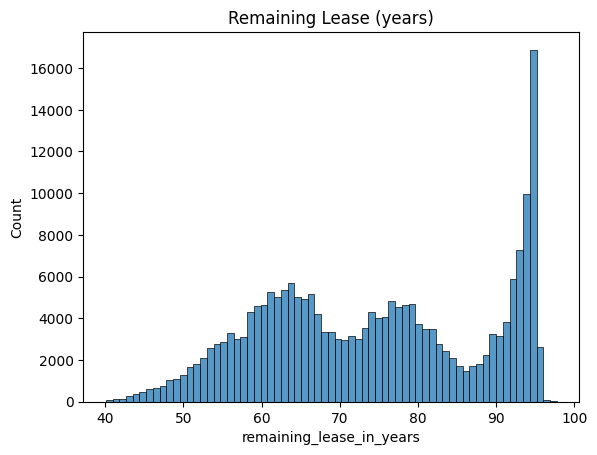

Multiple "peaks" suggesting different clusters/cohorts of flats built that are now in the secondary market.


In [ ]:
ax = sns.histplot(df['remaining_lease_in_years'])
plt.title("Remaining Lease (years)")
plt.show()

print('Multiple "peaks" suggesting different clusters/cohorts of flats built that are now in the secondary market.')
print('Most flats sold have more than 90 years on their lease suggesting they are newer flats.')

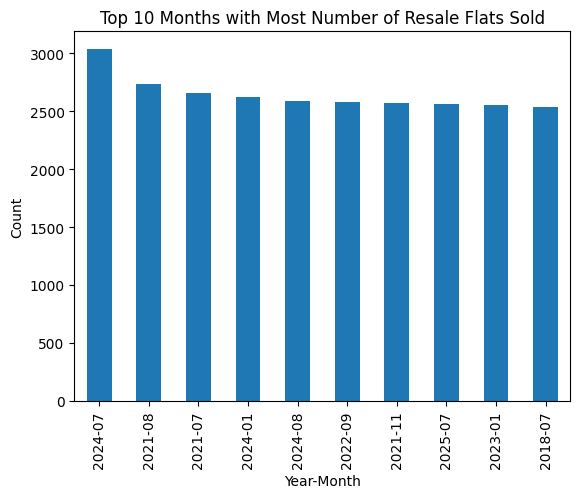

In [ ]:
ax = df['month'].value_counts().head(10).plot(kind='bar', title='Top 10 Months with Most Number of Resale Flats Sold')
ax.set_ylabel("Count")
ax.set_xlabel('Year-Month')
plt.show()

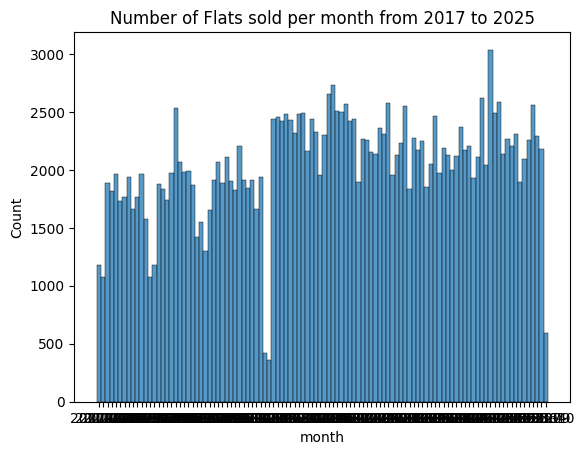

In [ ]:
ax = sns.histplot(df['month'])
plt.title("Number of Flats sold per month from 2017 to 2025")
plt.show()

Text(0, 0.5, 'Count')

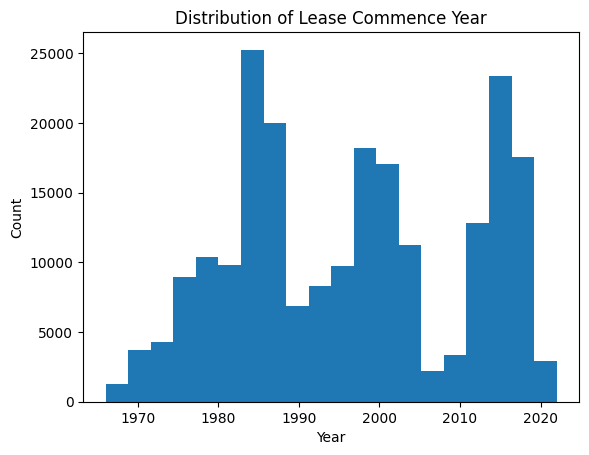

In [ ]:
ax = df['lease_commence_date'].plot(title ='Distribution of Lease Commence Year',kind='hist', bins = 20)
ax.set_xlabel('Year')
ax.set_ylabel('Count')

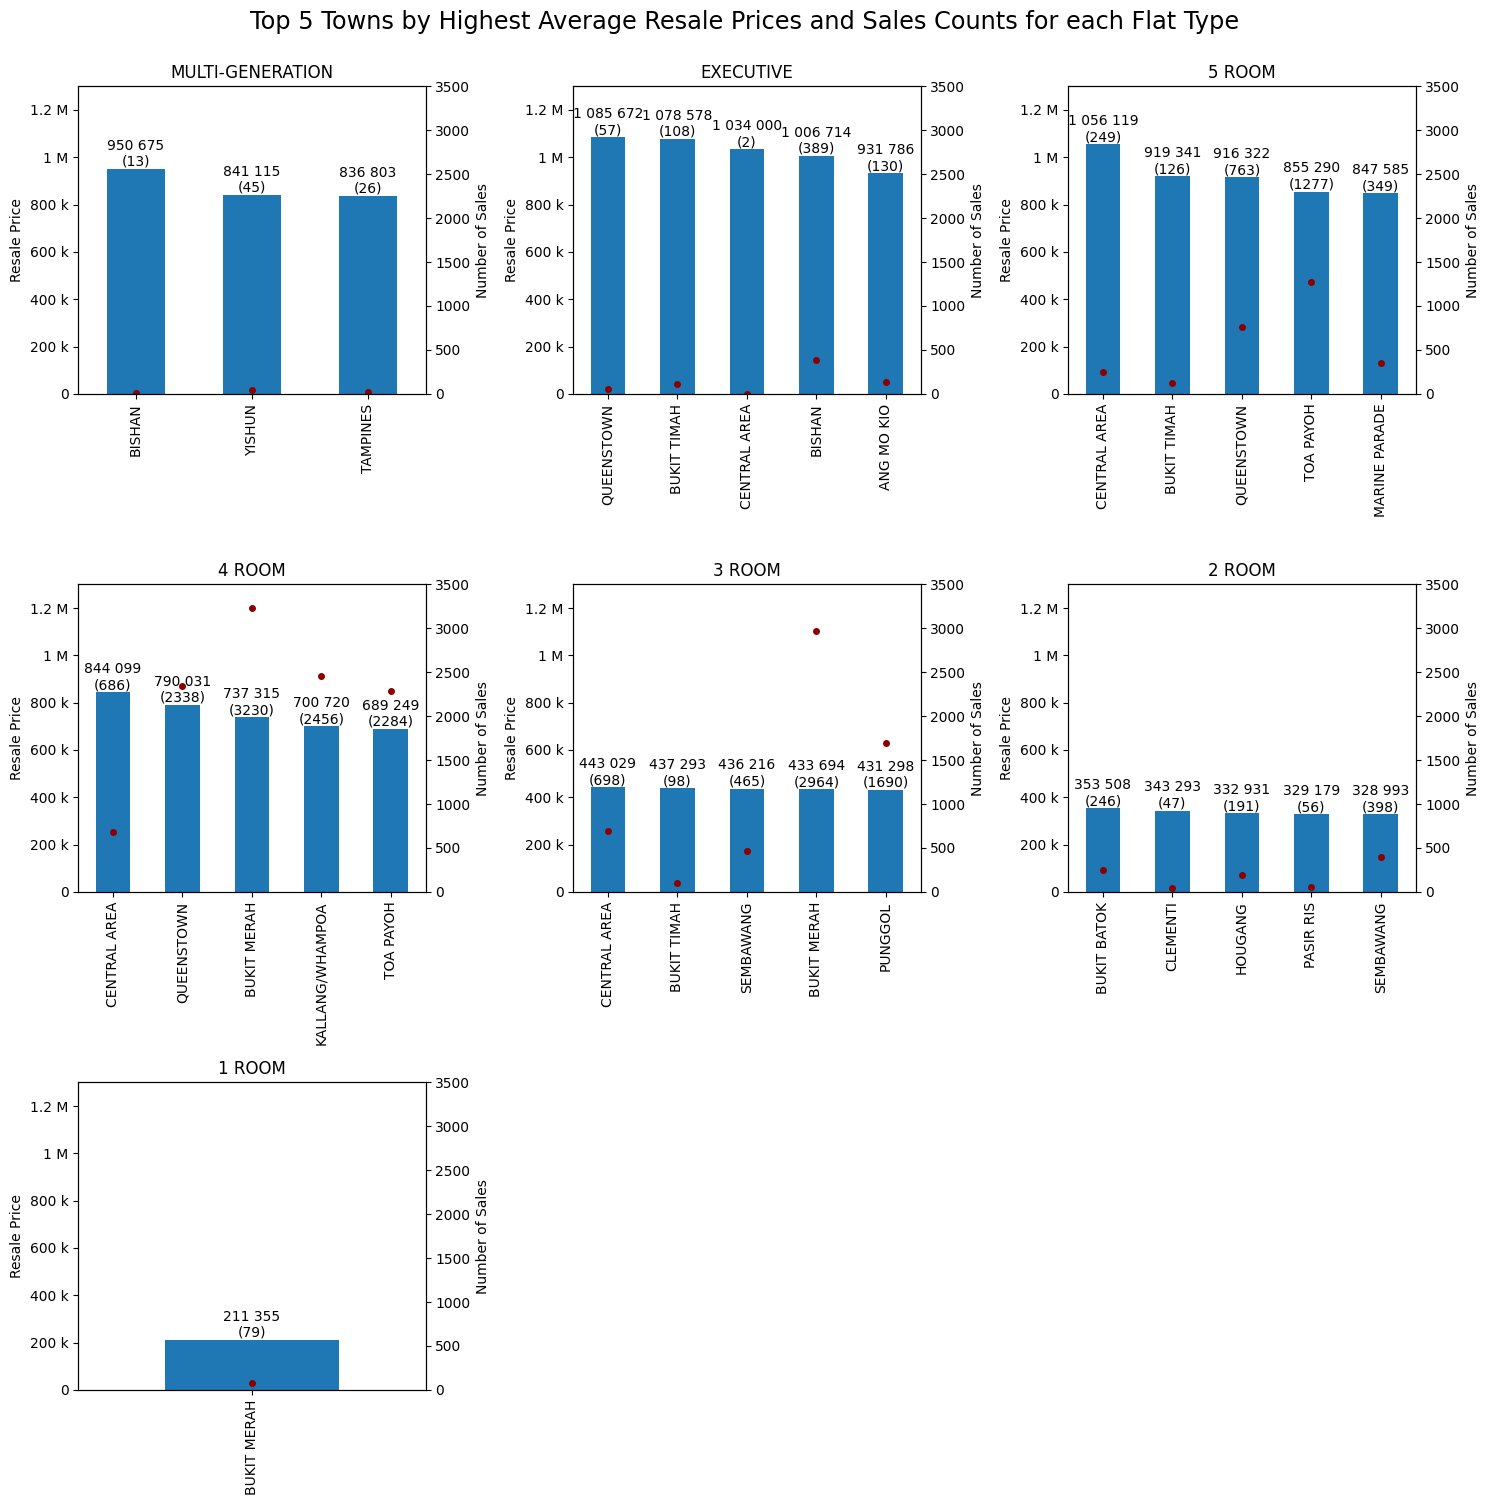

In [ ]:
sortList = df['flat_type'].unique().tolist()
sortList.sort(reverse = True) # sort flat type
n = len(sortList)

cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for index,name in enumerate(sortList):
  ax = axes[index]
  mean_prices = df[df['flat_type'] == name].groupby('town')['resale_price'].mean().sort_values(ascending = False).head() #resale price bar graph
  mean_prices.plot(kind = 'bar', title = name, ax=ax)
  ax.set_xlabel('')
  ax.set_ylabel('Resale Price')
  ax.set_ylim(0, 1300000)
  ax.yaxis.set_major_formatter(EngFormatter())

  ax2 = ax.twinx() #number of sales (dots)
  count_sales = df[df['flat_type'] == name].groupby('town')['resale_price'].count().reindex(mean_prices.index)
  ax2.plot(range(len(count_sales)), count_sales.values, color='darkred', marker='o',linestyle = '', markersize = 4)
  ax2.set_ylabel('Number of Sales')
  #ax2.tick_params(axis='y', labelcolor='darkred')
  ax2.set_ylim(0, 3500)

  for p,count in zip(ax.patches,count_sales): #add label on each bar
    value = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, value,  f'{value:,.0f}'.replace(',', ' ')+f'\n({count})', ha='center', va='bottom',) #syntax is x coord, ycoord, value, additional arguments


for i in range(index+1,len(axes)):
  fig.delaxes(axes[i])

fig.suptitle('Top 5 Towns by Highest Average Resale Prices and Sales Counts for each Flat Type', fontsize = 'xx-large', y=1)
plt.tight_layout()
plt.show()

From the plots above we observe the following:
1) Of all flat types, Executive and 5 Room flats have the highest resale values
2) Only 1 town with active sales of 1 Room flats, namely in Bukit Merah
3) There are 3 towns with active sales of multi-generation flats
4) Bukit Merah is a popular location, with high sales numbers for 3-room and 4-room flats despite having a high average resale price out of all the towns

# <ins>**Preparation for Regression**</ins>

In [ ]:
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,remaining_lease_in_months,remaining_lease_in_years,average_storey
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.00,Improved,1979,61 years 04 months,232000.00,736,61.33,11
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.00,New Generation,1978,60 years 07 months,250000.00,727,60.58,2
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,262000.00,749,62.42,2
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.00,New Generation,1980,62 years 01 month,265000.00,745,62.08,5
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,265000.00,749,62.42,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217648,2025-07,YISHUN,EXECUTIVE,824,YISHUN ST 81,04 TO 06,146.00,Maisonette,1987,61 years 05 months,980000.00,737,61.42,5
217649,2025-09,YISHUN,EXECUTIVE,877,YISHUN ST 81,10 TO 12,145.00,Maisonette,1987,61 years 03 months,980000.00,735,61.25,11
217650,2025-09,YISHUN,EXECUTIVE,834,YISHUN ST 81,04 TO 06,146.00,Maisonette,1988,61 years 04 months,990000.00,736,61.33,5
217651,2025-05,YISHUN,MULTI-GENERATION,632,YISHUN ST 61,04 TO 06,147.00,Multi Generation,1987,61 years 06 months,945000.00,738,61.50,5


In [ ]:
#pick features to regress on
features = ['town','flat_type','average_storey','floor_area_sqm','flat_model','remaining_lease_in_months']
#check the spread of categories
for col in features:
    print('\n',df[col].value_counts())


 town
SENGKANG           17814
PUNGGOL            15854
WOODLANDS          15404
YISHUN             14833
TAMPINES           14802
JURONG WEST        14369
BEDOK              11317
HOUGANG            10978
CHOA CHU KANG       9847
BUKIT BATOK         8983
ANG MO KIO          8879
BUKIT MERAH         8302
BUKIT PANJANG       7799
TOA PAYOH           6994
KALLANG/WHAMPOA     6643
SEMBAWANG           6523
PASIR RIS           6248
QUEENSTOWN          5885
GEYLANG             5349
CLEMENTI            4841
JURONG EAST         4431
SERANGOON           3872
BISHAN              3812
CENTRAL AREA        1705
MARINE PARADE       1333
BUKIT TIMAH          530
Name: count, dtype: int64

 flat_type
4 ROOM              92014
5 ROOM              53406
3 ROOM              51719
EXECUTIVE           15695
2 ROOM               4350
MULTI-GENERATION       84
1 ROOM                 79
Name: count, dtype: int64

 average_storey
5     49829
8     45544
11    40611
2     38376
14    20940
17     9797
20     4

In [ ]:
X = df[features]
y = df['resale_price']

#split test and train
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=67)

categorical_features = X.select_dtypes(include='object').columns.tolist()
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)], #process categorical columns
    remainder='passthrough'  # Leave numerical columns unchanged
)

# Create a pipeline: preprocess columns (encode catregories) then do regression
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=67))
])



print("Start training:", time.strftime('%H:%M:%S', time.gmtime()))
model_pipeline.fit(X_train, y_train)
print("End training:", time.strftime('%H:%M:%S', time.gmtime()))

X_train_encoded = model_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_encoded = model_pipeline.named_steps['preprocessor'].transform(X_test)


Start training: 15:57:09
End training: 15:58:08


In [ ]:
# use model to predict test and train sets
y_pred_xtest = model_pipeline.predict(X_test) # test set

maeTest = mean_absolute_error(y_test, y_pred_xtest) #ie how much predicted price differs from actual, on average
mseTest = mean_squared_error(y_test, y_pred_xtest) #average of squared errors, not much to interpret
rmseTest = np.sqrt(mseTest) # same unit as resale price so can just read. penalise large errors more than MAE, so RMSE > MAE means larger errors in my prediction. ie. it misses BIG TIME for some
r2Test = r2_score(y_test, y_pred_xtest)

print('\nErrors for Test set')
print(f"MAE: {maeTest:.2f}")
print(f"MSE: {mseTest:.2f}")
print(f"RMSE: {rmseTest:.2f}")
print(f"R² Score: {r2Test:.3f}")

y_pred_xtrain = model_pipeline.predict(X_train) # train set

maeTrain = mean_absolute_error(y_train, y_pred_xtrain) #ie how much predicted price differs from actual, on average
mseTrain = mean_squared_error(y_train, y_pred_xtrain) #average of squared errors, not much to interpret
rmseTrain = np.sqrt(mseTrain) # same unit as resale price so can just read. penalise large errors more than MAE, so RMSE > MAE means larger errors in my prediction. ie. it misses BIG TIME for some
r2Train = r2_score(y_train, y_pred_xtrain) #this is the amount of variance that my model can explain, 1 is best

print('\nErrors for Train set')
print(f"MAE: {maeTrain:.2f}")
print(f"MSE: {mseTrain:.2f}")
print(f"RMSE: {rmseTrain:.2f}")
print(f"R² Score: {r2Train:.3f}")


Errors for Test set
MAE: 42142.30
MSE: 3833619974.73
RMSE: 61916.23
R² Score: 0.889

Errors for Train set
MAE: 20117.66
MSE: 974840720.56
RMSE: 31222.44
R² Score: 0.972


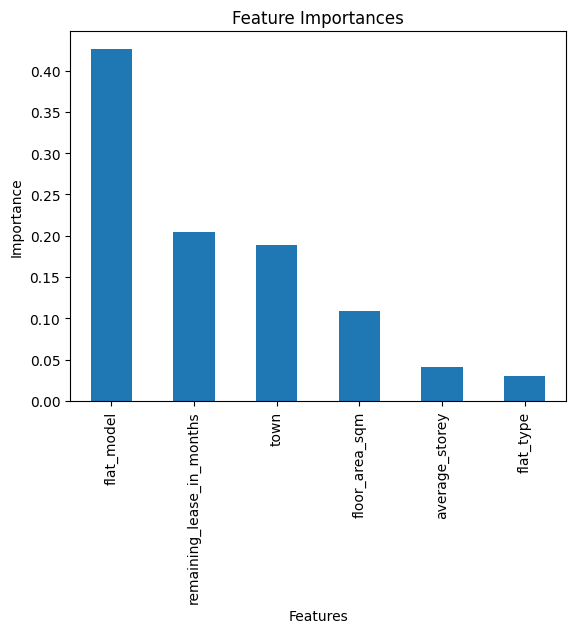

In [ ]:
# Plot feature importances
featureImpt = model_pipeline.named_steps['regressor'].feature_importances_

importances = pd.Series(featureImpt, index=X_train.columns).sort_values(ascending = False) # make it a dataframe and sort in descending order

plot = importances.plot(kind='bar')
plot.set(title='Feature Importances', xlabel='Features', ylabel='Importance')
plt.show()


Thus we observe that flat model is the most important feature in determining flat price, which is intuitive.

The second and third important features are remaning lease and the town, both of which are similarly important to buyers.

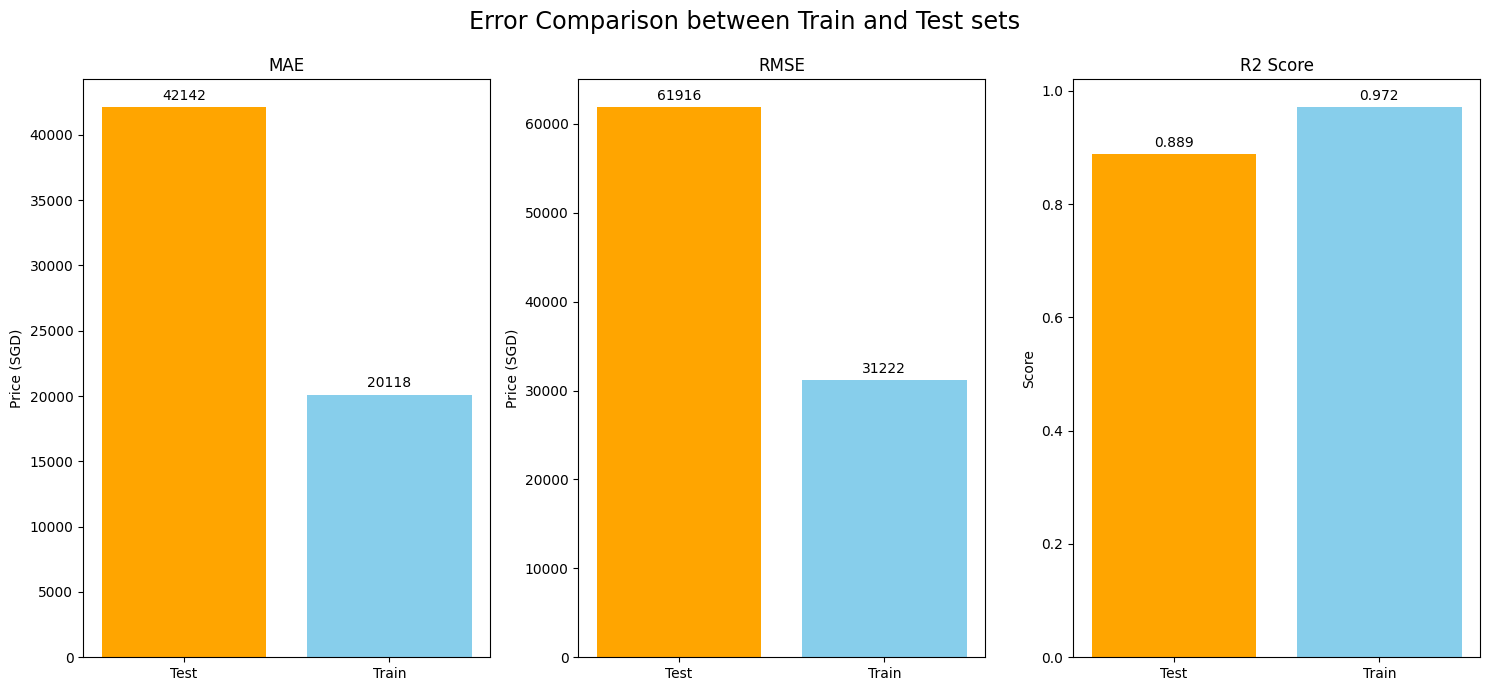

In [ ]:
labels = ['Test', 'Train']
colors = ['orange', 'skyblue']

fig, axs = plt.subplots(1, 3, figsize=(15,7))

# MAE plot
bars_mae = axs[0].bar(labels, [maeTest, maeTrain], color=colors)
axs[0].set_title('MAE')
axs[0].bar_label(bars_mae, fmt='%.0f', padding=3)
axs[0].set_ylabel('Price (SGD)')

# RMSE plot
bars_rmse = axs[1].bar(labels, [rmseTest, rmseTrain], color=colors)
axs[1].set_title('RMSE')
axs[1].bar_label(bars_rmse, fmt='%.0f', padding=3)
axs[1].set_ylabel('Price (SGD)')

# R2 plot
bars_r2 = axs[2].bar(labels, [r2Test, r2Train], color=colors)
axs[2].set_title('R2 Score')
axs[2].bar_label(bars_r2, fmt='%.3f', padding=3)
axs[2].set_ylabel('Score')

plt.suptitle('Error Comparison between Train and Test sets', size = 'xx-large')
plt.tight_layout(rect=[0, 0, 1, 0.99]) #customises size st it looks ok
plt.show()

In [ ]:
# hyperparameter tuning
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
    }

grid_search = GridSearchCV(
    estimator= RandomForestRegressor(random_state=67),
    param_grid=param_grid,
    cv = 3,
    scoring='neg_root_mean_squared_error',
    verbose = 2
)

grid_search.fit(X_train_final, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

bestModel = grid_search.best_estimator_

y_pred = bestModel.predict(X_test_final)

print('MAE:', mean_absolute_error(y_test, y_pred))
print("MSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

y_pred1 = bestModel.predict(X_train_final)
print('MAE:', mean_absolute_error(y_train, y_pred1))
print("MSE:", np.sqrt(mean_squared_error(y_train, y_pred1)))
print("R2 Score:", r2_score(y_train, y_pred1))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  25.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  25.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  24.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   9.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100

Based on our tuning, the optimal hyperparameters are max_depth=20, max_features='sqrt', n_estimators=300

In [ ]:
optimModel = RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=300, random_state=67)
optimModel.fit(X_train_encoded,y_train)

y_pred_xtestV2 = optimModel.predict(X_test_encoded)
maeTestV2 = mean_absolute_error(y_test, y_pred_xtestV2) #ie how much predicted price differs from actual, on average
mseTestV2 = mean_squared_error(y_test, y_pred_xtestV2) #average of squared errors, not much to interpret
rmseTestV2 = np.sqrt(mseTestV2) # same unit as resale price so can just read. penalise large errors more than MAE, so RMSE > MAE means larger errors in my prediction. ie. it misses BIG TIME for some
r2TestV2 = r2_score(y_test, y_pred_xtestV2) #this is the amount of variance that my model can explain, 1 is best

print('\nErrors for Test set')
print(f"MAE: {maeTestV2:.2f}")
print(f"MSE: {mseTestV2:.2f}")
print(f"RMSE: {rmseTestV2:.2f}")
print(f"R² Score: {r2TestV2:.3f}")

#find how the model fits training dataset, to check for over/under fitting
y_pred_xtrainV2 = optimModel.predict(X_train_encoded)
maeTrainV2 = mean_absolute_error(y_train, y_pred_xtrainV2) #ie how much predicted price differs from actual, on average
mseTrainV2 = mean_squared_error(y_train, y_pred_xtrainV2) #average of squared errors, not much to interpret
rmseTrainV2 = np.sqrt(mseTrainV2) # same unit as resale price so can just read. penalise large errors more than MAE, so RMSE > MAE means larger errors in my prediction. ie. it misses BIG TIME for some
r2TrainV2 = r2_score(y_train, y_pred_xtrainV2) #this is the amount of variance that my model can explain, 1 is best

print('\nErrors for Train set')
print(f"MAE: {maeTrainV2:.2f}")
print(f"MSE: {mseTrainV2:.2f}")
print(f"RMSE: {rmseTrainV2:.2f}")
print(f"R² Score: {r2TrainV2:.3f}")


Errors for Test set
MAE: 46005.38
MSE: 4266052246.02
RMSE: 65315.02
R² Score: 0.876

Errors for Train set
MAE: 35137.78
MSE: 2637640883.17
RMSE: 51357.97
R² Score: 0.923


In [ ]:
print(rmseTest,' and ',rmseTestV2)
print(rmseTrain,' and ',rmseTrainV2)

61916.233531504855  and  65315.02312656082
31222.439375605692  and  51357.968059197956


In [ ]:
print(maeTest,' and ', maeTestV2)
print(maeTrain,' and ', maeTrainV2)

42142.29881055734  and  46005.38196868631
20117.66487562535  and  35137.778768924276


Error for training set increased slightly, while test error remained relatively stable. This suggests the new model has reduced overfitting compared to the old model, which was what we aimed to do.

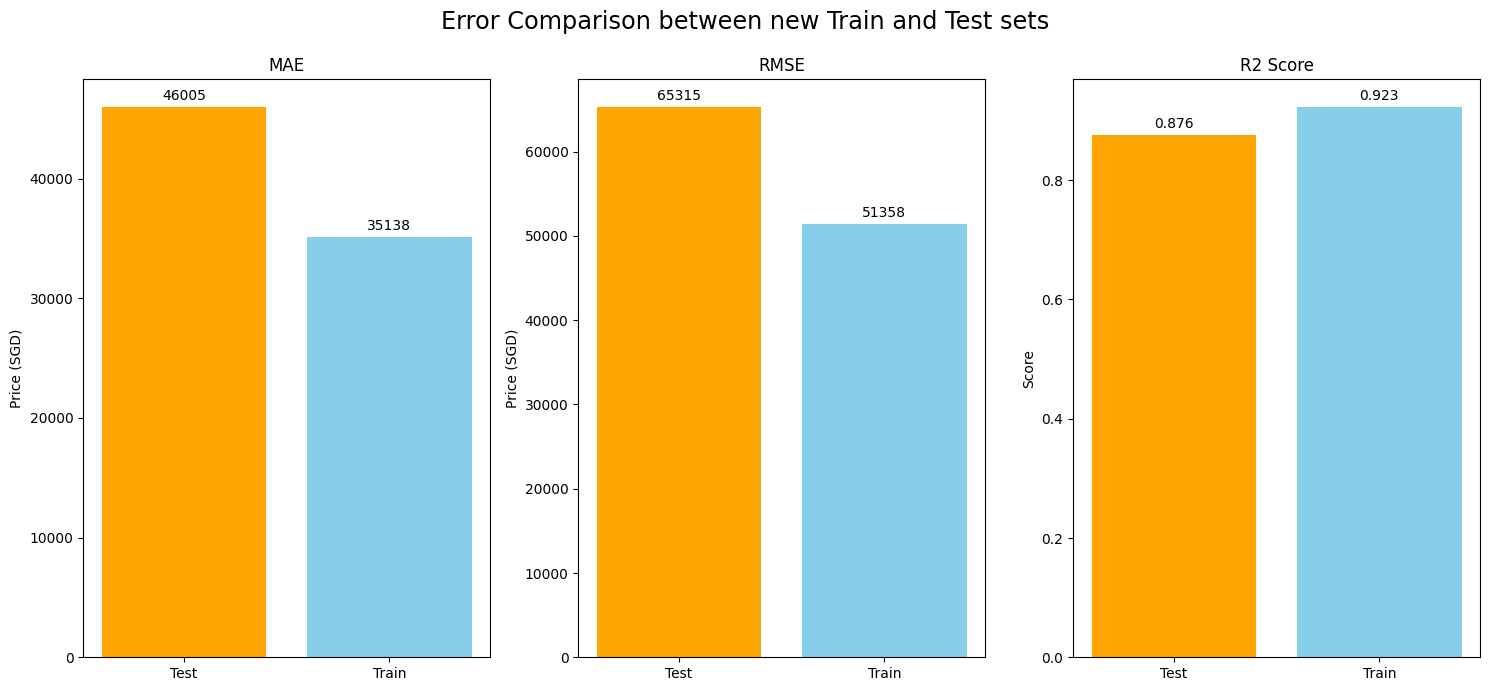

In [ ]:
labels = ['Test', 'Train']
colors = ['orange', 'skyblue']

fig, axs = plt.subplots(1, 3, figsize=(15,7))

# MAE plot
bars_mae = axs[0].bar(labels, [maeTestV2, maeTrainV2], color=colors)
axs[0].set_title('MAE')
axs[0].bar_label(bars_mae, fmt='%.0f', padding=3)
axs[0].set_ylabel('Price (SGD)')

# RMSE plot
bars_rmse = axs[1].bar(labels, [rmseTestV2, rmseTrainV2], color=colors)
axs[1].set_title('RMSE')
axs[1].bar_label(bars_rmse, fmt='%.0f', padding=3)
axs[1].set_ylabel('Price (SGD)')

# R2 plot
bars_r2 = axs[2].bar(labels, [r2TestV2, r2TrainV2], color=colors)
axs[2].set_title('R2 Score')
axs[2].bar_label(bars_r2, fmt='%.3f', padding=3)
axs[2].set_ylabel('Score')

plt.suptitle('Error Comparison between new Train and Test sets', size = 'xx-large')
plt.tight_layout(rect=[0, 0, 1, 0.99]) #customises size st it looks ok
plt.show()

In [ ]:
# save model to mounted google drive
from joblib import dump

model_path = '/content/drive/MyDrive/Colab Notebooks/final_model.pkl'

dump(optimModel, model_path)
print(f"Model saved to {model_path}")


Model saved to /content/drive/MyDrive/Colab Notebooks/final_model.pkl


In [ ]:
# load model from google drive
from joblib import load

model_path = '/content/drive/MyDrive/Colab Notebooks/final_model.pkl'
optimModel = load(model_path)
print(f"Model loaded from {model_path}")

Model loaded from /content/drive/MyDrive/Colab Notebooks/final_model.pkl
